# 1. Set Up

In [1]:
sp <- suppressPackageStartupMessages
sp(library(ggbiplot))
sp(library(dplyr))
sp(library(magrittr))
sp(library(tidyverse))
sp(library(gridExtra))

In [2]:
df_player <- read.csv("playerData.csv", sep = ",")
df_team <- read.csv("teamData.csv", sep = ",")
df_profile <- read.csv("player_profile.csv", sep = ",")
colnames(df_player)[colnames(df_player)=="X."] <- "no"
colnames(df_profile)[colnames(df_profile)=="X."] <- "no"

# Create working df
df <- inner_join(df_profile, df_player, by = c("teamID","no","year"))
head(df)

X.x,teamID,year,first_middle,last,pos1,pos2,nat,height_cm,no,...,factor,VOP,DRB,tAST,tFGM,tPACE,PER,lgPER,lgPACE,aPER
0,CTC,2017,Le,Nguycn,C,,Vietnam,NA,3,...,0.600327,0.8322544,0.720865,21.78571,31.92857,89.27824,2.7097793,3.873212,86.99707,10.226168
1,CTC,2017,Thanh,Hucnh,,,Vietnam,NA,4,...,0.600327,0.8322544,0.720865,21.78571,31.92857,89.27824,1.2909035,3.873212,86.99707,4.871613
2,CTC,2017,Nguycn,Hoang,,,Vietnam,NA,6,...,0.600327,0.8322544,0.720865,21.78571,31.92857,89.27824,0.5279444,3.873212,86.99707,1.992357
3,CTC,2017,Du-Minh,An,G,F,Vietnam,180,7,...,0.600327,0.8322544,0.720865,21.78571,31.92857,89.27824,1.2881894,3.873212,86.99707,4.861371
4,CTC,2017,Ngcc,Nguycn,,,Vietnam,NA,8,...,0.600327,0.8322544,0.720865,21.78571,31.92857,89.27824,1.3980769,3.873212,86.99707,5.276064
5,CTC,2017,Thanh,Dinh,,,Vietnam,NA,11,...,0.600327,0.8322544,0.720865,21.78571,31.92857,89.27824,11.8048814,3.873212,86.99707,44.549273


# 2. Preparing DFs for Classification

In [3]:
# Numerical vectors
stats <- c('fgm','fga', 'x3pm', 'x3pa', 'ftm', 'fta', 'oreb', 'dreb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts')
adv <- c('aRat', 'tRat','ts','eFG', 'aPER')

In [4]:
# Create Nationality Binary Labels
df["label"] <- ifelse(df["nat"]=="Vietnam","Local","Foreign")
head(df)

X.x,teamID,year,first_middle,last,pos1,pos2,nat,height_cm,no,...,VOP,DRB,tAST,tFGM,tPACE,PER,lgPER,lgPACE,aPER,label
0,CTC,2017,Le,Nguycn,C,,Vietnam,NA,3,...,0.8322544,0.720865,21.78571,31.92857,89.27824,2.7097793,3.873212,86.99707,10.226168,Local
1,CTC,2017,Thanh,Hucnh,,,Vietnam,NA,4,...,0.8322544,0.720865,21.78571,31.92857,89.27824,1.2909035,3.873212,86.99707,4.871613,Local
2,CTC,2017,Nguycn,Hoang,,,Vietnam,NA,6,...,0.8322544,0.720865,21.78571,31.92857,89.27824,0.5279444,3.873212,86.99707,1.992357,Local
3,CTC,2017,Du-Minh,An,G,F,Vietnam,180,7,...,0.8322544,0.720865,21.78571,31.92857,89.27824,1.2881894,3.873212,86.99707,4.861371,Local
4,CTC,2017,Ngcc,Nguycn,,,Vietnam,NA,8,...,0.8322544,0.720865,21.78571,31.92857,89.27824,1.3980769,3.873212,86.99707,5.276064,Local
5,CTC,2017,Thanh,Dinh,,,Vietnam,NA,11,...,0.8322544,0.720865,21.78571,31.92857,89.27824,11.8048814,3.873212,86.99707,44.549273,Local


# 3. Graphical K-Mean Labeling for 2019 subset

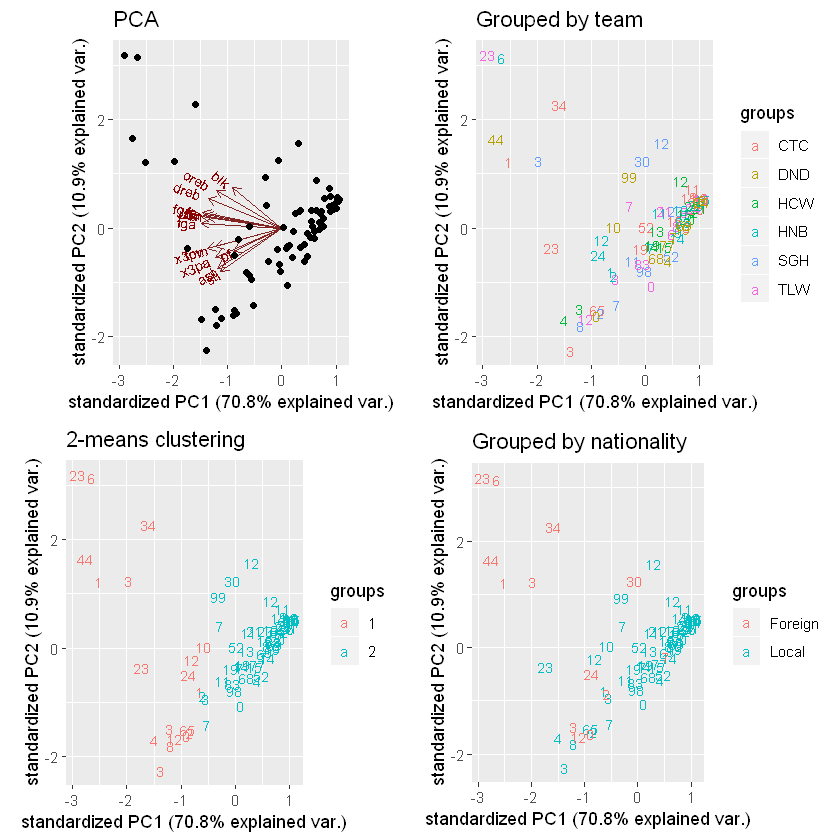

In [5]:
test <- subset(df, year==2019)
df19 <- test

# Plot 1 (showing PCA)
player.pca <- prcomp(df19[,stats],center = TRUE, scale. = TRUE)
p1 <- ggbiplot(player.pca,ellipse=FALSE,var.axes=TRUE) +
    ggtitle("PCA")

# Plot 2 (by team)
p2 <- ggbiplot(player.pca,ellipse=FALSE,labels=df19$no,groups=df19$team,var.axes=FALSE) +
    ggtitle("Grouped by team")

# Plot 3 (2-mean)
set.seed(50)
player.cluster <- kmeans(df19[,stats], 2)
df19$clusters <- as.factor(player.cluster$cluster)
p3 <- ggbiplot(player.pca,ellipse=FALSE,labels=df19$no,groups=df19$clusters,var.axes=FALSE) +
    ggtitle("2-means clustering")

# Plot 4 (by nationality)
p4 <- ggbiplot(player.pca,ellipse=FALSE,labels=df19$no,groups=df19$label,var.axes=FALSE) +
    ggtitle("Grouped by nationality")

# Plot all
grid.arrange(p1,p2,p3,p4,nrow=2,ncol=2)

# 4. Decision Tree

In [6]:
# Import Library
library(rpart)

# Create Train set from 2017 & 2018
train <- subset(df,year==2017|year==2018)
model <- paste("label ~ ", paste(stats, collapse= "+"))

# Fit model, predicting 'label' from all basic stats
tree.fit <- rpart(model, data = train, method = 'class')
print('Feature importance vector:')
tree.fit$variable.importance

# Prediction
treepred <- predict(tree.fit,test,type='class')

# Accuracy Score
tree.mat <- table(test$label, treepred)
tree.mat
tree.acc <- sum(diag(tree.mat)) / sum(tree.mat)
print(paste('Accuracy for test:', tree.acc))

[1] "Feature importance vector:"


ftm        fta        pts        fga        fgm       dreb       oreb 
18.5508060 16.1826180 14.9985240 14.3954234 14.3954234 10.2400409  5.2289411 
       tov       x3pm 
 1.1619869  0.5809935

         treepred
          Foreign Local
  Foreign      10     3
  Local        11    57

[1] "Accuracy for test: 0.827160493827161"


# 5. Gradient Boosting

In [7]:
# Import Library
sp(library(xgboost))

# Preparing matrix
train_label = as.matrix(ifelse(train$label=="Local",0,1))
test_label = as.matrix(ifelse(test$label=="Local",0,1))
train_data = data.matrix(train[,stats])
test_data = data.matrix(test[,stats])
dtrain <- xgb.DMatrix(data = train_data,label = train_label) 
dtest <- xgb.DMatrix(data = test_data,label=test_label)

# default parameters
params <- list(booster = "gbtree", objective = "binary:logistic", eta=0.3, gamma=0, max_depth=6, min_child_weight=1, subsample=1, colsample_bytree=1)

# Fit model, predicting 'label' from all basic stats

xgb <- xgb.train (params = params, data = dtrain, nrounds = 100,
                  watchlist = list(val=dtest,train=dtrain), verbose = 0,
                  early_stopping_rounds = 10, eval_metric = "error")
print('Feature importance vector:')
xgb.importance(feature_names = colnames(train_data),model = xgb)

# Prediction (with threshold probability being set at 0.7)
xgbpred <- predict (xgb,dtest)
xgbpred <- ifelse (xgbpred > 0.7,1,0)

# Accuracy Score
print("With 'local' being re-labeled as 0, and 'foreign' being re-labled as 1")
xgb.mat <- table(xgbpred, test_label)
xgb.mat
xgb.acc <- sum(diag(xgb.mat)) / sum(xgb.mat)
print(paste('Accuracy for test:', xgb.acc))

[1] "Feature importance vector:"


Feature,Gain,Cover,Frequency
ftm,0.415249671,0.255842656,0.16666667
oreb,0.126631588,0.193588935,0.14197531
blk,0.119155060,0.102190535,0.06790123
stl,0.112315394,0.110436504,0.12962963
fga,0.047361285,0.076573776,0.09876543
ast,0.040062965,0.098200722,0.08024691
pts,0.034931260,0.030866949,0.04938272
tov,0.029851156,0.039320964,0.06790123
x3pm,0.024529029,0.018079036,0.04320988
pf,0.018791296,0.024420565,0.03703704


[1] "With 'local' being re-labeled as 0, and 'foreign' being re-labled as 1"


       test_label
xgbpred  0  1
      0 68  7
      1  0  6

[1] "Accuracy for test: 0.91358024691358"


# 7. SVM

In [8]:
# Train & Predict
sp(library(e1071))
svm.fit <- svm(train_data,train_label,type='C-classification',kernel = "radial", cost = 10, scale = TRUE)
svm.pred <- predict(svm.fit,test_data)

# Accuracy Score
print("With 'local' being re-labeled as 0, and 'foreign' being re-labled as 1")
svm.mat <- table(svm.pred, test_label)
svm.mat
svm.acc <- sum(diag(svm.mat)) / sum(svm.mat)
print(paste('Accuracy for test:', svm.acc))

[1] "With 'local' being re-labeled as 0, and 'foreign' being re-labled as 1"


        test_label
svm.pred  0  1
       0 67  4
       1  1  9

[1] "Accuracy for test: 0.938271604938272"


# 8. Plot all predictions

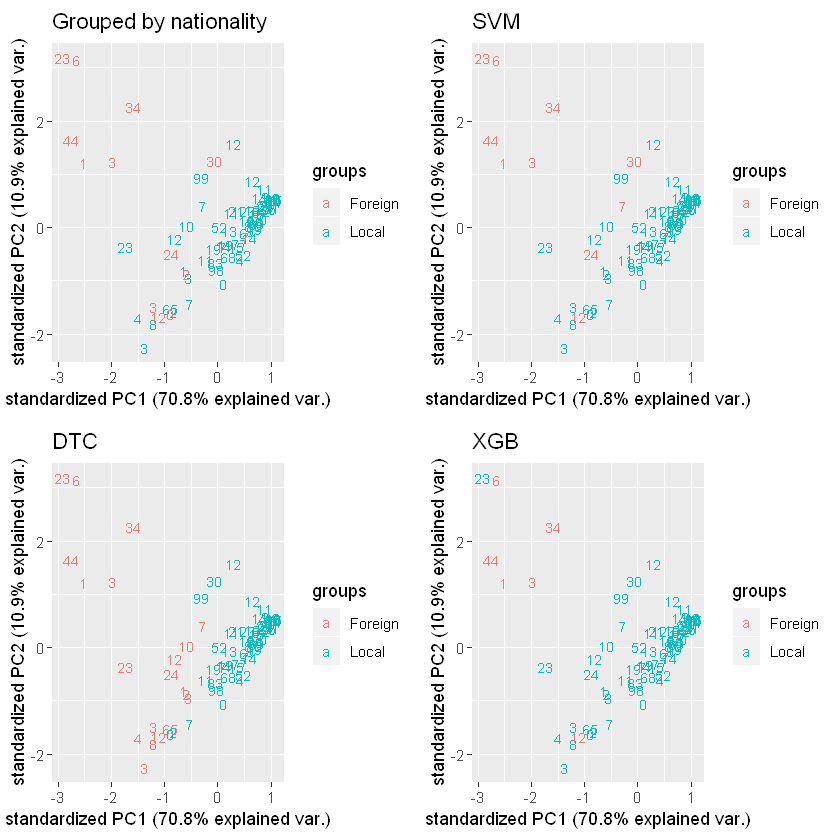

In [9]:
df19$dtc <- treepred
df19$xgb <- ifelse (xgbpred== 0,"Local","Foreign")
df19$svm <- ifelse (svm.pred== 0,"Local","Foreign")

# Plot (SVM)
p.svm <- ggbiplot(player.pca,ellipse=FALSE,labels=df19$no,groups=df19$svm,var.axes=FALSE) +
    ggtitle("SVM")

# Plot (DTC)
p.dtc <- ggbiplot(player.pca,ellipse=FALSE,labels=df19$no,groups=df19$dtc,var.axes=FALSE) +
    ggtitle("DTC")

# Plot (XGB)
p.xgb <- ggbiplot(player.pca,ellipse=FALSE,labels=df19$no,groups=df19$xgb,var.axes=FALSE) +
    ggtitle("XGB")

# Plot all
grid.arrange(p4,p.svm, p.dtc,p.xgb,nrow=2,ncol=2)

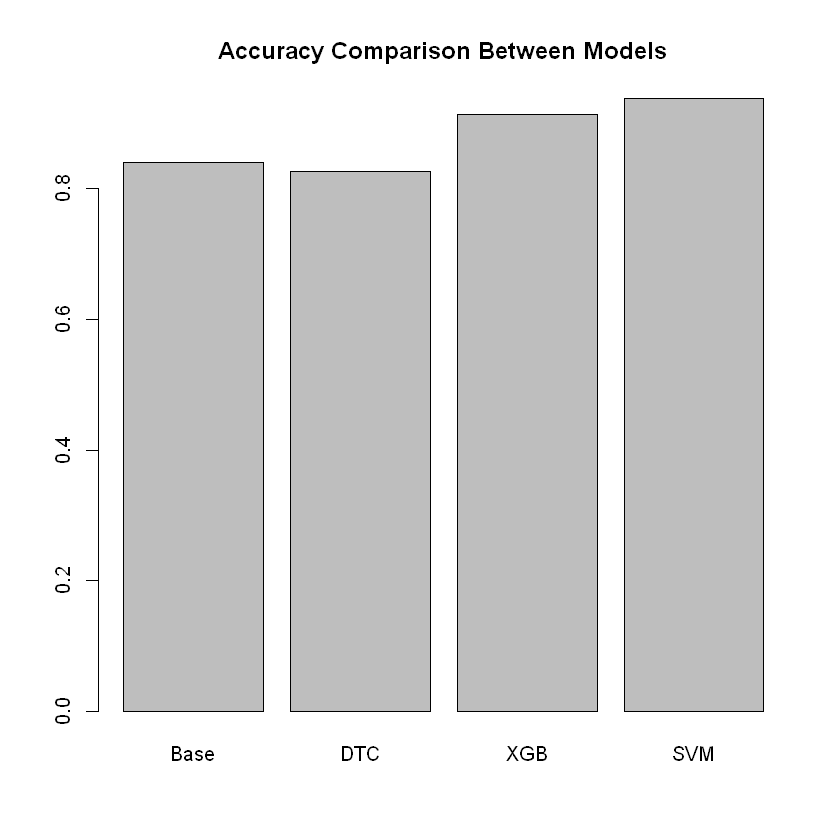

In [10]:
# Accuracy if all instances are labeled "Local"
base.acc <- (1-sum(test_label)/dim(test_data))[1]
acc <- c(base.acc, tree.acc,xgb.acc,svm.acc)
barplot(acc, main="Accuracy Comparison Between Models",
   names.arg=c("Base","DTC","XGB","SVM"))

# 9. PC Analysis of  Star & Superstar players

[1] "No of stars per team in 2019:"


teamID,n
CTC,6
DND,3
HCW,2
HNB,5
SGH,4
TLW,3


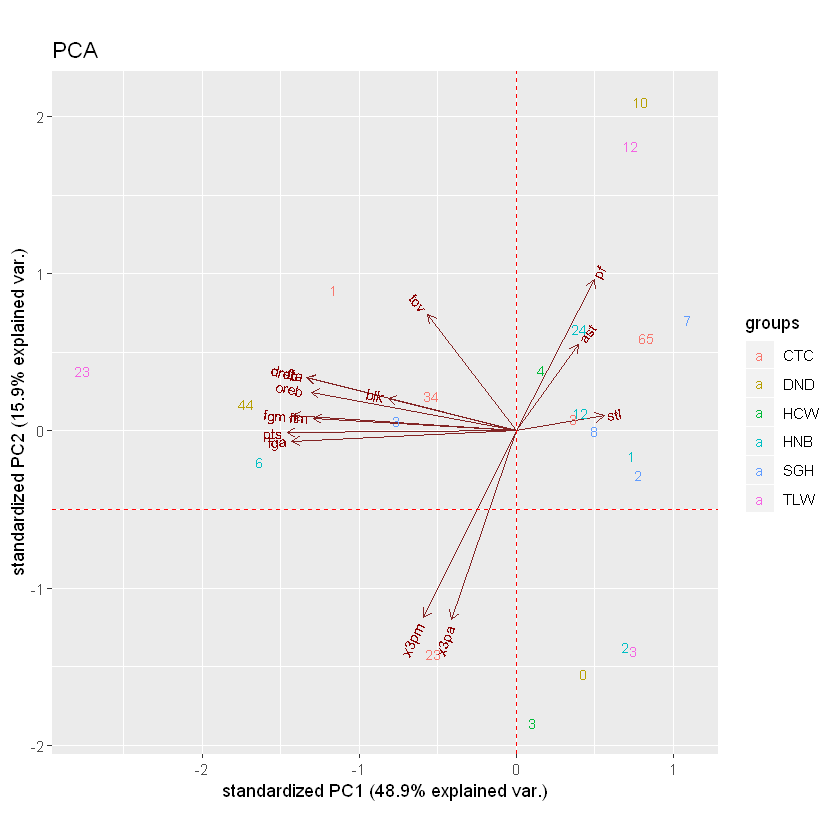

In [32]:
df19$pc <- scale(player.pca$x[,"PC1"])
# Select left half (more Foreign players -> more stars)
stars <- subset(df19,pc < -0.5)
print("No of stars per team in 2019:")
count(stars,teamID)
stars.pca <- prcomp(stars[,stats],center = TRUE, scale. = TRUE)
ggbiplot(stars.pca,ellipse=FALSE,var.axes=TRUE,labels=stars$no,groups=stars$team) +
    ggtitle("PCA") + geom_hline(yintercept=-0.5,linetype="dashed", color = "red") +
    geom_vline(xintercept=0,linetype="dashed", color = "red")

In [49]:
best <- stars[,c("teamID","first_middle","last","pos1","height_cm","no","PER","label","dtc","xgb","svm")]
best <- head(best[order(-best$PER),],7)
best

,teamID,first_middle,last,pos1,height_cm,no,PER,label,dtc,xgb,svm
198,HNB,Michael,Bell,F,206,6,24.88415,Foreign,Foreign,Foreign,Foreign
179,TLW,Zach,Allmon,F,203,23,22.04217,Foreign,Foreign,Local,Foreign
217,DND,Anthony,January,F,203,44,21.44876,Foreign,Foreign,Foreign,Foreign
127,CTC,Tam-Dinh,Thanh,F,192,23,20.59242,Local,Foreign,Local,Local
126,CTC,DeAngelo,Hamilton,F,203,1,18.38678,Foreign,Foreign,Foreign,Foreign
131,CTC,Michael,Vigilance,F,203,34,16.63392,Foreign,Foreign,Foreign,Foreign
95,SGH,Tavarion,Nix,PF,201,3,16.06750,Foreign,Foreign,Foreign,Foreign
